# Linear Regression Model for Temperature Forecasting

This notebook prepares data for training a linear regression model to predict hourly temperatures at RDU Airport.

**Training Period**: August 16, 2024 - August 16, 2025 (1 year)

**Prediction Target**: September 17-30, 2025 (14 days, 336 hours)

## 1. Import Libraries

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Training Data

In [23]:
# Load the training dataset
df = pd.read_csv('data/raw/linear_regression_training_set_2024-08-16_to_2025-08-16.csv')

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"\nColumns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (8784, 5)
Date range: 2024-08-16 00:00:00 to 2025-08-16 23:00:00

Columns: ['time', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'dew_point_2m']

First 5 rows:


,time,temperature_2m,relative_humidity_2m,pressure_msl,dew_point_2m
0,2024-08-16 00:00:00,20.6,85,1018.8,18.0
1,2024-08-16 01:00:00,20.4,84,1018.8,17.6
2,2024-08-16 02:00:00,19.7,85,1018.2,17.1
3,2024-08-16 03:00:00,19.2,86,1018.2,16.8
4,2024-08-16 04:00:00,18.5,91,1018.0,17.0


In [24]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()

Missing values per column:
time                    0
temperature_2m          0
relative_humidity_2m    0
pressure_msl            0
dew_point_2m            0
dtype: int64

Basic statistics:


,time,temperature_2m,relative_humidity_2m,pressure_msl,dew_point_2m
count,8784,8784.000000,8784.000000,8784.000000,8784.000000
mean,2025-02-14 23:30:00,16.135610,69.855305,1018.655567,10.007878
min,2024-08-16 00:00:00,-9.800000,19.000000,993.400000,-18.300000
25%,2024-11-15 11:45:00,9.200000,54.000000,1014.600000,2.300000
50%,2025-02-14 23:30:00,17.700000,71.000000,1018.500000,12.000000
75%,2025-05-17 11:15:00,23.300000,88.000000,1022.700000,18.700000
max,2025-08-16 23:00:00,37.600000,100.000000,1043.700000,26.000000
std,NaN,9.292655,20.023273,6.433295,10.183780


## 3. Feature Engineering - Cyclical Encoding

Time features (hour, day) are cyclical. Hour 23 is close to hour 0, and December 31 is close to January 1.

We encode these as sine/cosine pairs to capture their circular nature:
- **Hour**: 0-23 → (hour_sin, hour_cos)
- **Day of Year**: 1-365 → (day_sin, day_cos)

In [25]:
# Extract temporal features
df['hour'] = df['time'].dt.hour
df['day_of_year'] = df['time'].dt.dayofyear

# Cyclical encoding for hour (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding for day of year (1-365 or 1-366 for leap years)
# Use 365.25 to account for leap years
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

print("Cyclical features created!")
print("\nFeature columns:")
print(df.columns.tolist())
print("\nSample of cyclical features:")
df[['time', 'hour', 'hour_sin', 'hour_cos', 'day_of_year', 'day_sin', 'day_cos']].head(10)

Cyclical features created!

Feature columns:
['time', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'dew_point_2m', 'hour', 'day_of_year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Sample of cyclical features:


,time,hour,hour_sin,hour_cos,day_of_year,day_sin,day_cos
0,2024-08-16 00:00:00,0,0.000000,1.000000e+00,229,-0.715795,-0.69831
1,2024-08-16 01:00:00,1,0.258819,9.659258e-01,229,-0.715795,-0.69831
2,2024-08-16 02:00:00,2,0.500000,8.660254e-01,229,-0.715795,-0.69831
3,2024-08-16 03:00:00,3,0.707107,7.071068e-01,229,-0.715795,-0.69831
4,2024-08-16 04:00:00,4,0.866025,5.000000e-01,229,-0.715795,-0.69831
5,2024-08-16 05:00:00,5,0.965926,2.588190e-01,229,-0.715795,-0.69831
6,2024-08-16 06:00:00,6,1.000000,6.123234e-17,229,-0.715795,-0.69831
7,2024-08-16 07:00:00,7,0.965926,-2.588190e-01,229,-0.715795,-0.69831
8,2024-08-16 08:00:00,8,0.866025,-5.000000e-01,229,-0.715795,-0.69831
9,2024-08-16 09:00:00,9,0.707107,-7.071068e-01,229,-0.715795,-0.69831


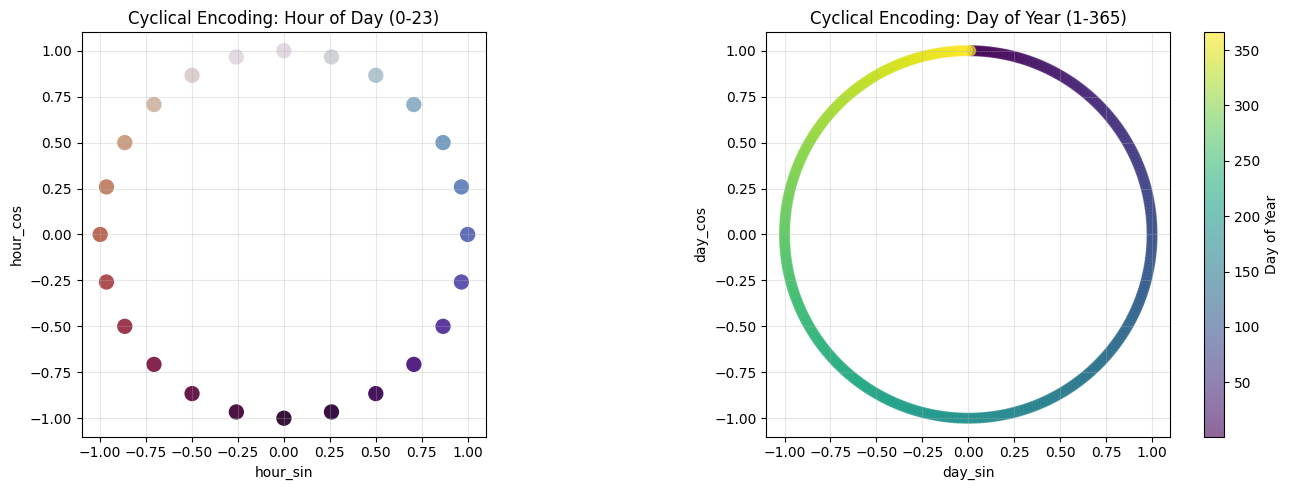

✓ Cyclical features preserve circular relationships!


In [26]:
# Visualize cyclical encoding for hour
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hour encoding
sample_hours = df[['hour', 'hour_sin', 'hour_cos']].drop_duplicates().sort_values('hour')
axes[0].scatter(sample_hours['hour_sin'], sample_hours['hour_cos'], c=sample_hours['hour'], cmap='twilight', s=100)
axes[0].set_xlabel('hour_sin')
axes[0].set_ylabel('hour_cos')
axes[0].set_title('Cyclical Encoding: Hour of Day (0-23)')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Day encoding
sample_days = df[['day_of_year', 'day_sin', 'day_cos']].drop_duplicates().sort_values('day_of_year')
scatter = axes[1].scatter(sample_days['day_sin'], sample_days['day_cos'], c=sample_days['day_of_year'], 
                          cmap='viridis', s=50, alpha=0.6)
axes[1].set_xlabel('day_sin')
axes[1].set_ylabel('day_cos')
axes[1].set_title('Cyclical Encoding: Day of Year (1-365)')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1], label='Day of Year')

plt.tight_layout()
plt.show()

print("✓ Cyclical features preserve circular relationships!")

## 4. Temporal Train/Validation Split

**Important**: We do NOT shuffle the data. We split chronologically:
- **Training set**: Earlier 80% of data
- **Validation set**: Later 20% of data

This simulates real-world forecasting where we train on past data and validate on future data.

In [27]:
# Ensure data is sorted by time (should already be sorted)
df = df.sort_values('time').reset_index(drop=True)

# Calculate split index (80/20 split)
train_size = 0.8
split_idx = int(len(df) * train_size)

# Split the data chronologically
train_df = df.iloc[:split_idx].copy()
val_df = df.iloc[split_idx:].copy()

print(f"{'='*60}")
print(f"TEMPORAL TRAIN/VALIDATION SPLIT")
print(f"{'='*60}")
print(f"\nTotal records: {len(df):,}")
print(f"\nTrain set:")
print(f"  - Size: {len(train_df):,} records ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Date range: {train_df['time'].min()} to {train_df['time'].max()}")
print(f"\nValidation set:")
print(f"  - Size: {len(val_df):,} records ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Date range: {val_df['time'].min()} to {val_df['time'].max()}")
print(f"\n✓ Temporal split complete - NO shuffling used!")
print(f"{'='*60}")

TEMPORAL TRAIN/VALIDATION SPLIT

Total records: 8,784

Train set:
  - Size: 7,027 records (80.0%)
  - Date range: 2024-08-16 00:00:00 to 2025-06-04 18:00:00

Validation set:
  - Size: 1,757 records (20.0%)
  - Date range: 2025-06-04 19:00:00 to 2025-08-16 23:00:00

✓ Temporal split complete - NO shuffling used!


## 5. Summary of Prepared Data

In [28]:
# Display feature columns
feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                'relative_humidity_2m', 'pressure_msl', 'dew_point_2m']
target_col = 'temperature_2m'

print("Feature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nTarget column: {target_col}")

print("\n" + "="*60)
print("Training set preview:")
print("="*60)
print(train_df[['time'] + feature_cols + [target_col]].head(10))

print("\n" + "="*60)
print("Validation set preview:")
print("="*60)
print(val_df[['time'] + feature_cols + [target_col]].head(10))

Feature columns:
  1. hour_sin
  2. hour_cos
  3. day_sin
  4. day_cos
  5. relative_humidity_2m
  6. pressure_msl
  7. dew_point_2m

Target column: temperature_2m

Training set preview:
                 time  hour_sin      hour_cos   day_sin  day_cos  \
0 2024-08-16 00:00:00  0.000000  1.000000e+00 -0.715795 -0.69831   
1 2024-08-16 01:00:00  0.258819  9.659258e-01 -0.715795 -0.69831   
2 2024-08-16 02:00:00  0.500000  8.660254e-01 -0.715795 -0.69831   
3 2024-08-16 03:00:00  0.707107  7.071068e-01 -0.715795 -0.69831   
4 2024-08-16 04:00:00  0.866025  5.000000e-01 -0.715795 -0.69831   
5 2024-08-16 05:00:00  0.965926  2.588190e-01 -0.715795 -0.69831   
6 2024-08-16 06:00:00  1.000000  6.123234e-17 -0.715795 -0.69831   
7 2024-08-16 07:00:00  0.965926 -2.588190e-01 -0.715795 -0.69831   
8 2024-08-16 08:00:00  0.866025 -5.000000e-01 -0.715795 -0.69831   
9 2024-08-16 09:00:00  0.707107 -7.071068e-01 -0.715795 -0.69831   

   relative_humidity_2m  pressure_msl  dew_point_2m  temperature

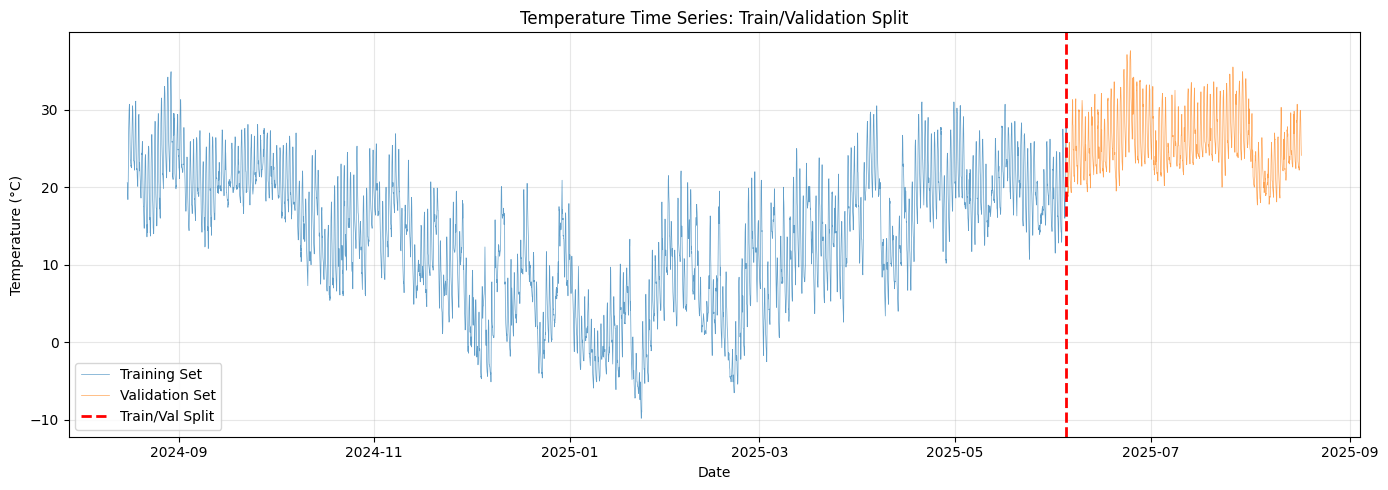


✓ Data preparation complete!

Next steps:
  1. Build linear regression model
  2. Train on training set
  3. Evaluate on validation set
  4. Make predictions for Sep 17-30, 2025


In [29]:
# Visualize the temporal split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_df['time'], train_df['temperature_2m'], label='Training Set', alpha=0.7, linewidth=0.5)
ax.plot(val_df['time'], val_df['temperature_2m'], label='Validation Set', alpha=0.7, linewidth=0.5)
ax.axvline(x=train_df['time'].max(), color='red', linestyle='--', linewidth=2, label='Train/Val Split')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Time Series: Train/Validation Split')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Data preparation complete!")
print("\nNext steps:")
print("  1. Build linear regression model")
print("  2. Train on training set")
print("  3. Evaluate on validation set")
print("  4. Make predictions for Sep 17-30, 2025")

## 6. Build Linear Regression Model

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define feature columns and target
feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                'relative_humidity_2m', 'pressure_msl', 'dew_point_2m']
target_col = 'temperature_2m'

# Prepare training data
X_train = train_df[feature_cols]
y_train = train_df[target_col]

# Prepare validation data
X_val = val_df[feature_cols]
y_val = val_df[target_col]

print("Feature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

print(f"\n✓ Data prepared for modeling!")

Feature matrix shapes:
  X_train: (7027, 7)
  y_train: (7027,)
  X_val: (1757, 7)
  y_val: (1757,)

✓ Data prepared for modeling!


## 7. Train the Model

In [31]:
# Initialize and train the linear regression model
model = LinearRegression()

print("Training linear regression model...")
model.fit(X_train, y_train)

print("✓ Model training complete!")
print(f"\nModel intercept: {model.intercept_:.4f}")
print(f"\nFeature coefficients:")
for feature, coef in zip(feature_cols, model.coef_):
    print(f"  {feature:25s}: {coef:10.4f}")

Training linear regression model...
✓ Model training complete!

Model intercept: 34.8235

Feature coefficients:
  hour_sin                 :    -0.1485
  hour_cos                 :    -0.1732
  day_sin                  :     0.0996
  day_cos                  :    -0.1507
  relative_humidity_2m     :    -0.2428
  pressure_msl             :    -0.0119
  dew_point_2m             :     1.0441


## 8. Evaluate on Validation Set

In [32]:
# Make predictions on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

# Display results
print(f"{'='*60}")
print(f"MODEL EVALUATION RESULTS")
print(f"{'='*60}\n")

print("Training Set Performance:")
print(f"  MAE:  {train_mae:.4f} °C")
print(f"  RMSE: {train_rmse:.4f} °C")
print(f"  R²:   {train_r2:.4f}")

print("\nValidation Set Performance:")
print(f"  MAE:  {val_mae:.4f} °C")
print(f"  RMSE: {val_rmse:.4f} °C")
print(f"  R²:   {val_r2:.4f}")

print(f"\n{'='*60}")

# Add predictions to dataframes for visualization
train_df['predictions'] = y_train_pred
val_df['predictions'] = y_val_pred

MODEL EVALUATION RESULTS

Training Set Performance:
  MAE:  0.6454 °C
  RMSE: 0.8646 °C
  R²:   0.9899

Validation Set Performance:
  MAE:  0.5585 °C
  RMSE: 0.6992 °C
  R²:   0.9700



Mean Absolute Error (MAE) takes every prediction error, removes the sign, and calculates for the average error rate. With a rate of around 0.55, it's even below the human detection threshold of around 1-2 degrees Celsius. Our model is performing well.

Root Mean Square Error (RMSE) penalizes larger errors more. Our RMSE/MAE ratio of 1.25 suggests consistent errors without too high of outliers.

With an R^2 of 0.97, our features capture mostly all of the predictable patterns in temperature.

## 9. Test on Real September 2025 Data

Test the model on the actual September 17-30, 2025 period.

In [33]:
# Load the September 2025 test set
test_df = pd.read_csv('data/raw/rdu_test_set_2025-09-17_to_2025-09-30.csv')

# Convert time to datetime
test_df['time'] = pd.to_datetime(test_df['time'])

print(f"Test Set Loaded:")
print(f"  Shape: {test_df.shape}")
print(f"  Date range: {test_df['time'].min()} to {test_df['time'].max()}")
print(f"  Total hours: {len(test_df)}")
print(f"\nColumns: {list(test_df.columns)}")
print(f"\nFirst 5 rows:")
test_df.head()

Test Set Loaded:
  Shape: (336, 5)
  Date range: 2025-09-17 00:00:00 to 2025-09-30 23:00:00
  Total hours: 336

Columns: ['time', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'dew_point_2m']

First 5 rows:


,time,temperature_2m,relative_humidity_2m,pressure_msl,dew_point_2m
0,2025-09-17 00:00:00,16.3,80,1019.4,12.8
1,2025-09-17 01:00:00,16.2,80,1018.3,12.8
2,2025-09-17 02:00:00,15.9,82,1017.7,12.8
3,2025-09-17 03:00:00,15.9,83,1017.1,12.9
4,2025-09-17 04:00:00,16.3,82,1016.8,13.2


In [34]:
# Apply same feature engineering to test set
test_df['hour'] = test_df['time'].dt.hour
test_df['day_of_year'] = test_df['time'].dt.dayofyear

# Cyclical encoding
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day_of_year'] / 365.25)
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day_of_year'] / 365.25)

# Prepare test features
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print("✓ Test set features prepared!")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nTest features preview:")
print(X_test.head())

✓ Test set features prepared!
  X_test: (336, 7)
  y_test: (336,)

Test features preview:
   hour_sin  hour_cos   day_sin   day_cos  relative_humidity_2m  pressure_msl  \
0  0.000000  1.000000 -0.971395 -0.237468                    80        1019.4   
1  0.258819  0.965926 -0.971395 -0.237468                    80        1018.3   
2  0.500000  0.866025 -0.971395 -0.237468                    82        1017.7   
3  0.707107  0.707107 -0.971395 -0.237468                    83        1017.1   
4  0.866025  0.500000 -0.971395 -0.237468                    82        1016.8   

   dew_point_2m  
0          12.8  
1          12.8  
2          12.8  
3          12.9  
4          13.2  


In [35]:
# Make predictions on the September 2025 test set
y_test_pred = model.predict(X_test)

# Calculate test set metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"{'='*60}")
print(f"SEPTEMBER 2025 TEST SET RESULTS")
print(f"{'='*60}\n")

print(f"Test Period: September 17-30, 2025")
print(f"Total Hours: {len(y_test)}")
print(f"\nTest Set Performance:")
print(f"  MAE:  {test_mae:.4f} °C")
print(f"  RMSE: {test_rmse:.4f} °C")
print(f"  R²:   {test_r2:.4f}")

print(f"\n{'='*60}")
print(f"COMPARISON ACROSS ALL DATASETS")
print(f"{'='*60}\n")

comparison_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test (Sep 2025)'],
    'MAE (°C)': [train_mae, val_mae, test_mae],
    'RMSE (°C)': [train_rmse, val_rmse, test_rmse],
    'R²': [train_r2, val_r2, test_r2]
})
print(comparison_df.to_string(index=False))

# Add predictions to test dataframe
test_df['predictions'] = y_test_pred

print(f"\n✓ September 2025 predictions complete!")

SEPTEMBER 2025 TEST SET RESULTS

Test Period: September 17-30, 2025
Total Hours: 336

Test Set Performance:
  MAE:  0.5393 °C
  RMSE: 0.6243 °C
  R²:   0.9752

COMPARISON ACROSS ALL DATASETS

        Dataset  MAE (°C)  RMSE (°C)       R²
       Training  0.645414   0.864645 0.989862
     Validation  0.558484   0.699176 0.970011
Test (Sep 2025)  0.539340   0.624335 0.975155

✓ September 2025 predictions complete!


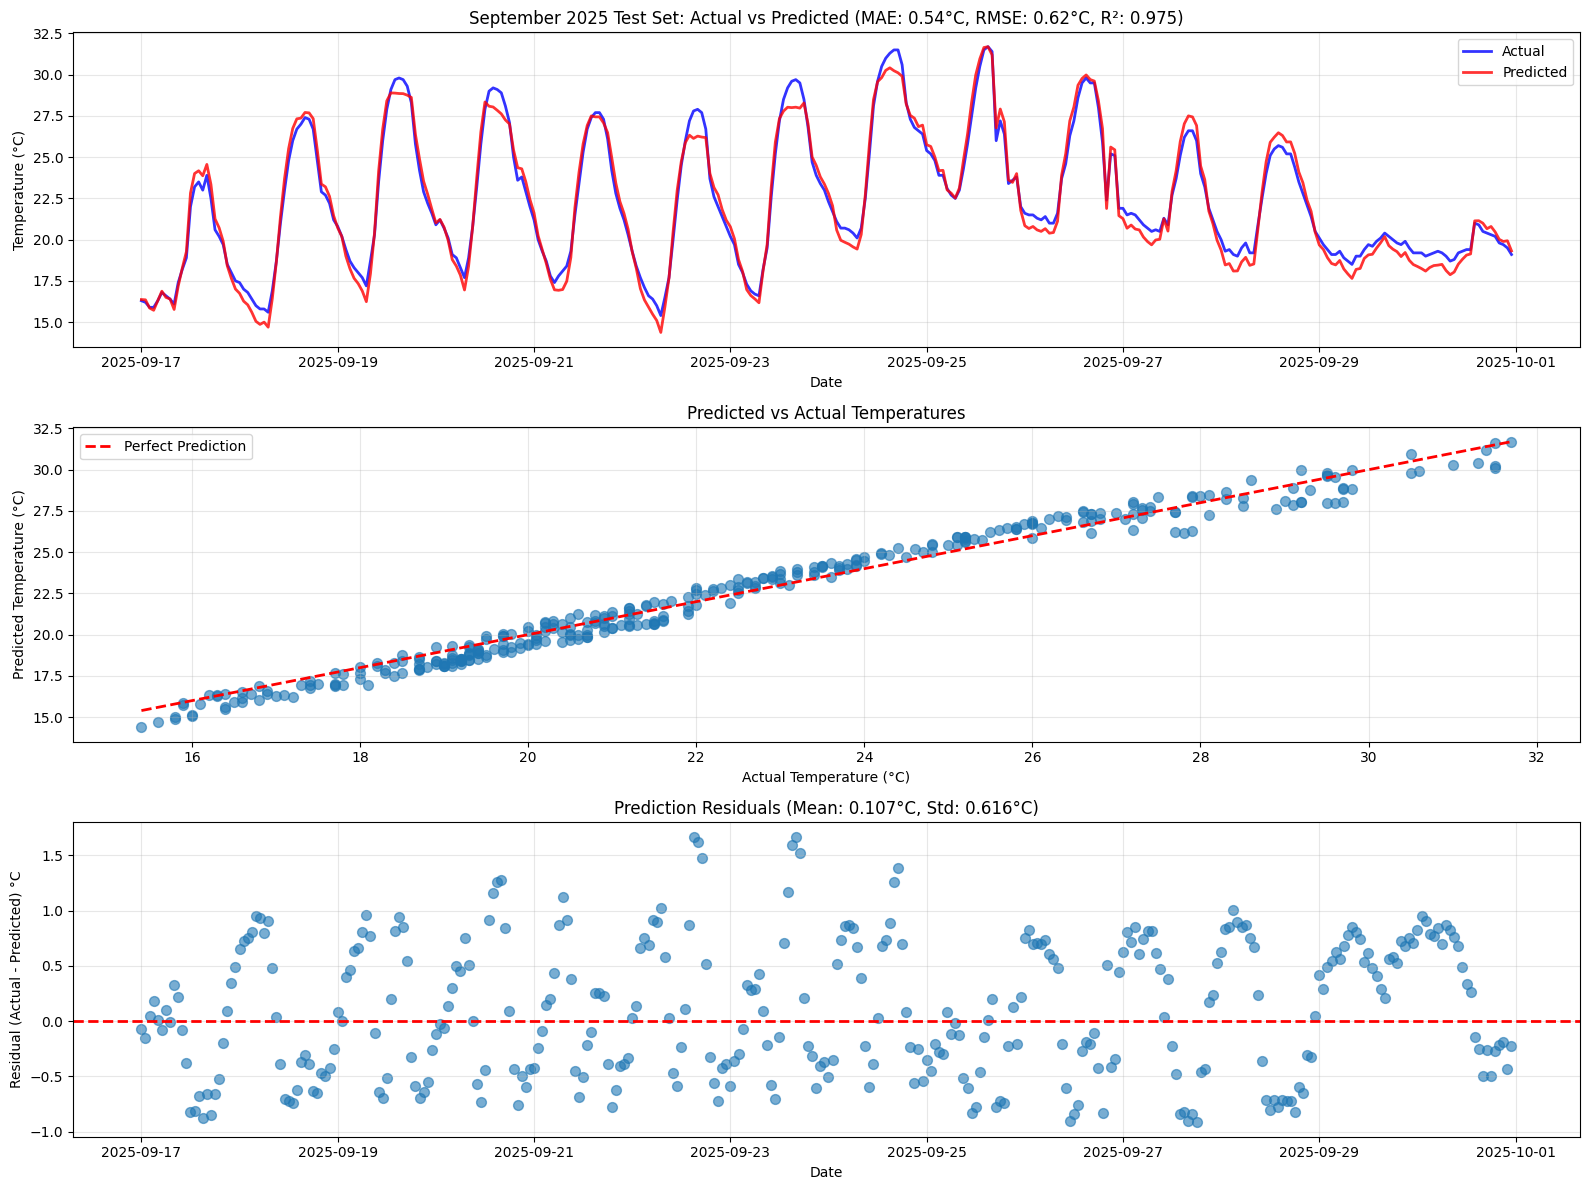


✓ Visualization complete!

Residual Statistics:
  Mean error: 0.1069°C
  Std deviation: 0.6160°C
  Max overestimate: -0.9167°C
  Max underestimate: 1.6706°C


In [36]:
# Visualize September 2025 test set predictions
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Time series plot
axes[0].plot(test_df['time'], test_df['temperature_2m'], label='Actual', alpha=0.8, linewidth=2, color='blue')
axes[0].plot(test_df['time'], test_df['predictions'], label='Predicted', alpha=0.8, linewidth=2, color='red')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title(f'September 2025 Test Set: Actual vs Predicted (MAE: {test_mae:.2f}°C, RMSE: {test_rmse:.2f}°C, R²: {test_r2:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: predicted vs actual
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Temperature (°C)')
axes[1].set_ylabel('Predicted Temperature (°C)')
axes[1].set_title('Predicted vs Actual Temperatures')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred
axes[2].scatter(test_df['time'], residuals, alpha=0.6, s=50)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Residual (Actual - Predicted) °C')
axes[2].set_title(f'Prediction Residuals (Mean: {residuals.mean():.3f}°C, Std: {residuals.std():.3f}°C)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")
print(f"\nResidual Statistics:")
print(f"  Mean error: {residuals.mean():.4f}°C")
print(f"  Std deviation: {residuals.std():.4f}°C")
print(f"  Max overestimate: {residuals.min():.4f}°C")
print(f"  Max underestimate: {residuals.max():.4f}°C")

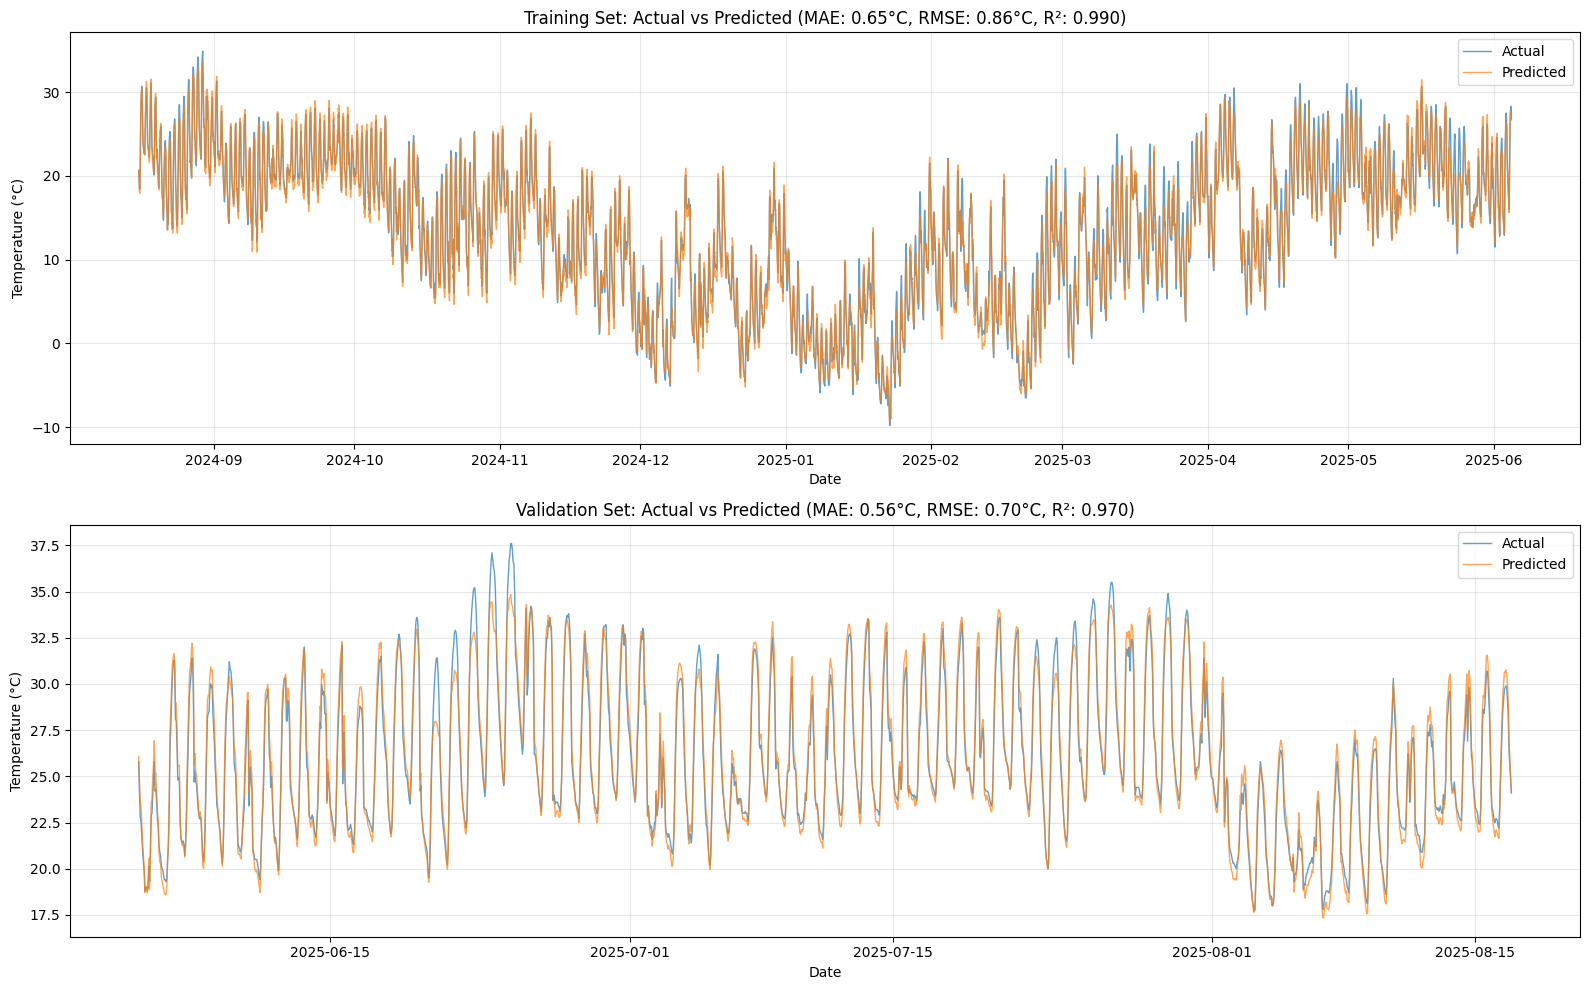

In [37]:
# Visualize predictions vs actual temperatures
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Training set visualization
axes[0].plot(train_df['time'], train_df['temperature_2m'], label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(train_df['time'], train_df['predictions'], label='Predicted', alpha=0.7, linewidth=1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title(f'Training Set: Actual vs Predicted (MAE: {train_mae:.2f}°C, RMSE: {train_rmse:.2f}°C, R²: {train_r2:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set visualization
axes[1].plot(val_df['time'], val_df['temperature_2m'], label='Actual', alpha=0.7, linewidth=1)
axes[1].plot(val_df['time'], val_df['predictions'], label='Predicted', alpha=0.7, linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title(f'Validation Set: Actual vs Predicted (MAE: {val_mae:.2f}°C, RMSE: {val_rmse:.2f}°C, R²: {val_r2:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

No decrease in performance from validation to test set. Model is able to generalize patterns well and predict hourly temperature quite accurately. 

Test set performance actually exceeded validation set, meaning september weather patterns are highly predictable.

Time to beat this with a second one!